#Introduction

Ce notebook présente la réalisation et l’évaluaton d'un système d’attaque adverse dans le domaine de l’identification faciale.

Dans un premier temps nous entrainerons un modèle d'identification faciale. Ensuite nous comparerons ses résultats par rapport à un modèle pré-entrainé. Enfin nous attaquerons les modèles à l'aide de l'attaque de projected gradient descent et nous comparerons les performances avant/après.

#Imports

In [3]:
%tensorflow_version 2.x 
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import pandas as pd
import os
from scipy.stats import norm
from tqdm import tqdm

from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, \
  Conv2D, Conv2DTranspose, UpSampling2D, BatchNormalization,  RandomRotation,  RandomFlip, \
  LeakyReLU, Dropout, Rescaling, Add, GlobalAveragePooling2D, MaxPooling2D, Concatenate, Activation, MaxPool2D, Convolution2D, LocallyConnected2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.losses import MSE, sparse_categorical_crossentropy, binary_crossentropy
from keras.applications.vgg16 import VGG16
from tensorflow import keras

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.datasets import fetch_lfw_people, fetch_lfw_pairs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.io import imread



#Dataset et exploration

Pour ce projet nous utiliserons le dataset Labeled Faces in the Wild. LFW  est un dataset de photographies de visages conçue pour étudier le problème de la reconnaissance des visages. L'ensemble de données contient plus de 13 000 images de visages. Chaque visage a été étiqueté avec le nom de la personne photographiée.

Nous récuperons les images au format (152,152,3) et nous prenons que les personnes (classes) dont on a au moins 40 images.

In [2]:
lfw_people = fetch_lfw_people(color=True, min_faces_per_person=40, resize= 1, slice_ =(slice(48,200), slice(48,200)))
n_samples, h, w, n_c = lfw_people.images.shape
X = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print(n_classes, X.shape)

19 (1867, 152, 152, 3)


Affichons quelques images :

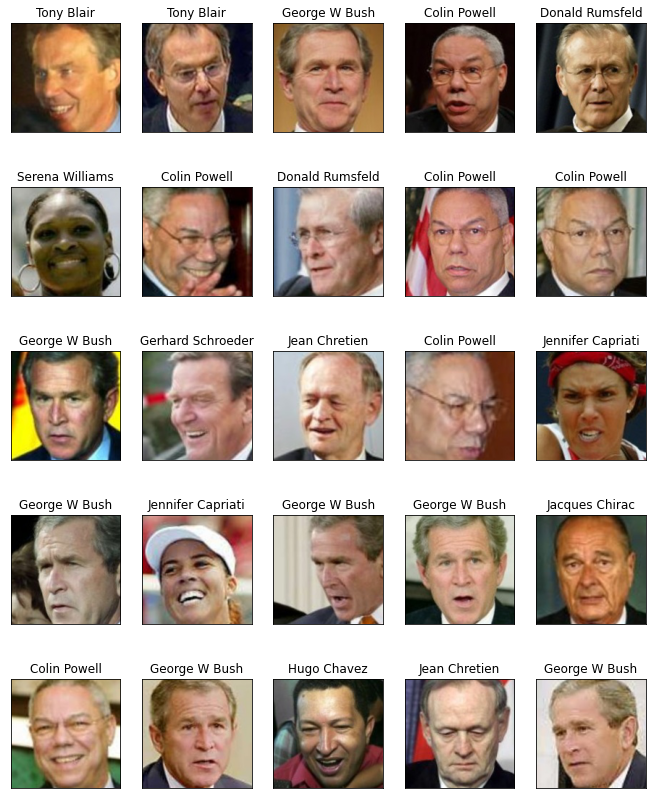

In [4]:
def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i]/255)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(X, target_names[y], 5, 5)

Voyons le nombre d'observations de chaque classe afin de vérifier que nous ne sommes pas en situation d'imbalanced dataset

In [5]:
df = pd.DataFrame(data={"label" : y, "name": target_names[y]})
df.groupby(["name", "label"]).size()

name                       label
Ariel Sharon               0         77
Arnold Schwarzenegger      1         42
Colin Powell               2        236
Donald Rumsfeld            3        121
George W Bush              4        530
Gerhard Schroeder          5        109
Gloria Macapagal Arroyo    6         44
Hugo Chavez                7         71
Jacques Chirac             8         52
Jean Chretien              9         55
Jennifer Capriati          10        42
John Ashcroft              11        53
Junichiro Koizumi          12        60
Laura Bush                 13        41
Lleyton Hewitt             14        41
Luiz Inacio Lula da Silva  15        48
Serena Williams            16        52
Tony Blair                 17       144
Vladimir Putin             18        49
dtype: int64

On voit que certaines classes sont surrepresentées (George W Bush par exemple). On va donc undersampler les données afin d'avoir maximum 80 images pour chaque classe.

In [6]:
X_new = []
y_new = []

count = np.zeros(n_classes)
for ele, label in zip(X,y):
  count[label] +=1
  if count[label] <= 80:
    X_new.append(ele)
    y_new.append(label)
X_new = np.array(X_new)
y_new = np.array(y_new)


print('Old:',X.shape,'  New:',X_new.shape)

Old: (1867, 152, 152, 3)   New: (1127, 152, 152, 3)


In [7]:
df = pd.DataFrame(data={"label" : y_new, "name": target_names[y_new]})
df.groupby(["name", "label"]).size()


name                       label
Ariel Sharon               0        77
Arnold Schwarzenegger      1        42
Colin Powell               2        80
Donald Rumsfeld            3        80
George W Bush              4        80
Gerhard Schroeder          5        80
Gloria Macapagal Arroyo    6        44
Hugo Chavez                7        71
Jacques Chirac             8        52
Jean Chretien              9        55
Jennifer Capriati          10       42
John Ashcroft              11       53
Junichiro Koizumi          12       60
Laura Bush                 13       41
Lleyton Hewitt             14       41
Luiz Inacio Lula da Silva  15       48
Serena Williams            16       52
Tony Blair                 17       80
Vladimir Putin             18       49
dtype: int64

#Pre-processing

Afin d'éviter l'overfitting on va utiliser de la data augmentation. La data augmentation est une des techniques utilisées pour augmenter la quantité de données en ajoutant des copies légèrement modifiées de données déjà existantes ou des données synthétiques nouvellement créées à partir des données existantes.

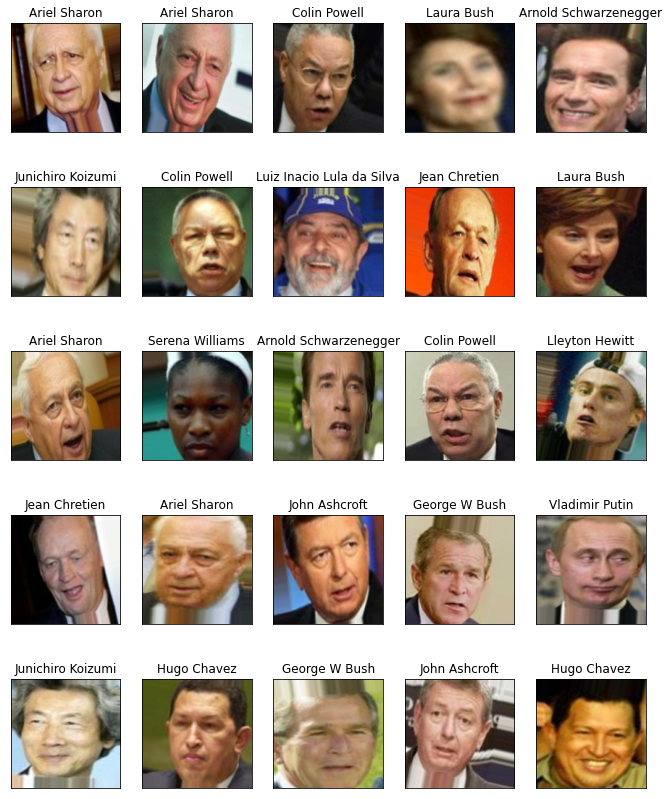

In [8]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')



for X_batch, y_batch in datagen.flow(X_new, y_new, batch_size=50):
  plot_gallery(X_batch, target_names[y_batch], 5, 5)
  break

#Entrainement du modèle 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)


train_generator = datagen.flow(X_train, y_train, batch_size=256)
test_generator = ImageDataGenerator().flow(X_test, y_test, batch_size=256)
validation_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=256)

In [10]:
from matplotlib import image
def adam_optimizer(lr=0.01):
    return tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.5)

def create_generator_cnn(seed_dim=42):

    img = keras.Input(shape=(152,152, 3))
    x = Conv2D(filters=64, kernel_size=2, padding='same',  input_shape=(152,152, 3))(img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(filters=32, kernel_size=2, padding='same')(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    outputs = Dense(n_classes, activation ='softmax')(x)

    model = keras.Model(inputs=[img], outputs=outputs)
    model.summary()


    model.compile(loss='sparse_categorical_crossentropy',
             optimizer=adam_optimizer(),
             metrics=['accuracy'])
    return model


In [11]:
model = create_generator_cnn()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 152, 152, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 152, 152, 64)      832       
                                                                 
 batch_normalization (BatchN  (None, 152, 152, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 152, 152, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 76, 76, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 76, 76, 32)        8224  

In [12]:
nb_epochs = 120
history = model.fit(train_generator, validation_data=validation_generator, epochs=nb_epochs, verbose = 1)

Epoch 1/120
4/4 [==============================] - 17s 913ms/step - loss: 3.3663 - accuracy: 0.1396 - val_loss: 1254.6445 - val_accuracy: 0.0780
Epoch 2/120
4/4 [==============================] - 4s 1s/step - loss: 2.3161 - accuracy: 0.2864 - val_loss: 381.8061 - val_accuracy: 0.0213
Epoch 3/120
4/4 [==============================] - 4s 1s/step - loss: 2.0077 - accuracy: 0.3633 - val_loss: 131.8618 - val_accuracy: 0.0851
Epoch 4/120
4/4 [==============================] - 5s 1s/step - loss: 1.7957 - accuracy: 0.4343 - val_loss: 75.7695 - val_accuracy: 0.0284
Epoch 5/120
4/4 [==============================] - 4s 945ms/step - loss: 1.6361 - accuracy: 0.4852 - val_loss: 49.3665 - val_accuracy: 0.1064
Epoch 6/120
4/4 [==============================] - 5s 2s/step - loss: 1.6238 - accuracy: 0.4828 - val_loss: 74.2854 - val_accuracy: 0.0426
Epoch 7/120
4/4 [==============================] - 5s 1s/step - loss: 1.5299 - accuracy: 0.5148 - val_loss: 36.4251 - val_accuracy: 0.0922
Epoch 8/120
4/4 

Voyons les performances du modèle.

In [13]:
def accuracy_loss_curves(history):
  # plot loss
  fig = plt.figure(figsize=(8,8))
  ax1 = fig.add_subplot(2,1,1)
  ax1.plot(history.history['loss'], label='train')
  ax1.plot(history.history['val_loss'], label='test')
  ax1.set_title('Cross Entropy Loss')
  ax1.legend(['Training Loss', 'Validation Loss'])
	# plot accuracy
  ax2 = fig.add_subplot(2,1,2)
  ax2.plot(history.history['accuracy'], label='train')
  ax2.plot(history.history['val_accuracy'], label='test')
  ax2.set_title('Classification Accuracy')
  ax2.legend(['Training Acc', 'Validation Acc'])

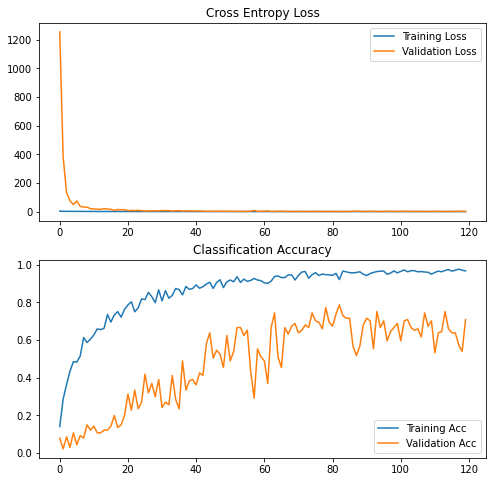

In [14]:
accuracy_loss_curves(history)

Voyons les résultats sur le jeu de données de test

In [15]:
y_pred = model.predict(X_test).argmax(axis=1)
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

             Ariel Sharon       0.90      0.82      0.86        11
    Arnold Schwarzenegger       0.30      0.60      0.40         5
             Colin Powell       0.86      0.75      0.80         8
          Donald Rumsfeld       0.57      0.89      0.70         9
            George W Bush       0.83      0.77      0.80        13
        Gerhard Schroeder       0.53      0.82      0.64        11
  Gloria Macapagal Arroyo       1.00      0.57      0.73         7
              Hugo Chavez       0.53      0.73      0.62        11
           Jacques Chirac       1.00      0.60      0.75         5
            Jean Chretien       0.80      0.50      0.62         8
        Jennifer Capriati       0.64      0.78      0.70         9
            John Ashcroft       0.62      0.71      0.67         7
        Junichiro Koizumi       1.00      0.67      0.80         3
               Laura Bush       1.00      0.50      0.67     

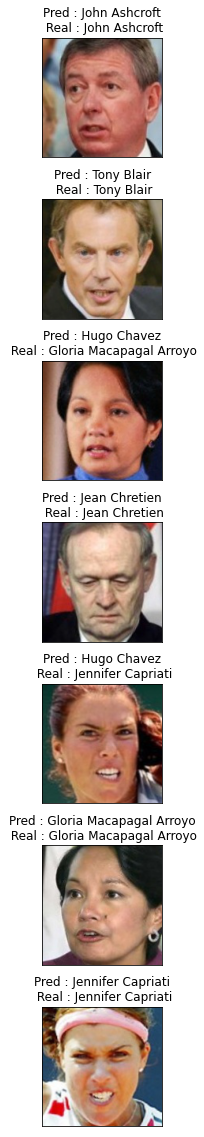

In [16]:
predictions=[]
for i in range(y_pred.shape[0]-1):
    predictions.append("Pred : "+target_names[y_pred[i]]+"\n Real : "+target_names[y_test[i]])

plot_gallery(X_test, predictions, 7,1)

Notre modèle propose de plutot bonnes performances. Comparons le maintenant à un modèle pré-entrainé.

#Modèle pré-entrainé

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


On va utiliser le modèle deep face et on va lui appliquer les poids pré-entrainé. On ajoute une layer Dense à la fin afin de bien s'integrer avec notre jeu de données.

In [19]:
def deep_face_model():
    model = Sequential()
    model.add(Convolution2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152, 3)))
    model.add(MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2'))
    model.add(Convolution2D(16, (9, 9), activation='relu', name='C3'))
    model.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4'))
    model.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5') )
    model.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6'))
    model.add(Flatten(name='F0'))
    model.add(Dense(4096, activation='relu', name='F7'))
    model.add(Dropout(rate=0.5, name='D0'))
    model.add(Dense(8631, activation='softmax', name='F8'))
    model.load_weights("./drive/MyDrive/VGGFace2_DeepFace_weights_val-0.9034.h5")
  

    x = Model(inputs=model.layers[0].input, outputs=model.layers[-3].output)
    x.trainable=False

    deepface_model = Sequential()
    deepface_model.add(x)
    deepface_model.add(Dense(n_classes , activation='softmax'))

    deepface_model.summary()

    deepface_model.compile(loss='sparse_categorical_crossentropy',
            optimizer=adam_optimizer(),
            metrics=['accuracy'])
    return deepface_model
    


In [21]:
model_pretrained = deep_face_model()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 4096)              102412864 
                                                                 
 dense_3 (Dense)             (None, 19)                77843     
                                                                 
Total params: 102,490,707
Trainable params: 77,843
Non-trainable params: 102,412,864
_________________________________________________________________


In [22]:
nb_epochs = 20
history = model_pretrained.fit(train_generator, validation_data=validation_generator, epochs=nb_epochs, verbose = 1)

Epoch 1/20
4/4 [==============================] - 121s 12s/step - loss: 1469.3663 - accuracy: 0.0746 - val_loss: 4833.7324 - val_accuracy: 0.1135
Epoch 2/20
4/4 [==============================] - 1s 337ms/step - loss: 4803.4932 - accuracy: 0.1172 - val_loss: 4215.5928 - val_accuracy: 0.1206
Epoch 3/20
4/4 [==============================] - 1s 336ms/step - loss: 4051.4592 - accuracy: 0.1385 - val_loss: 3379.6658 - val_accuracy: 0.1348
Epoch 4/20
4/4 [==============================] - 1s 335ms/step - loss: 1551.8695 - accuracy: 0.3538 - val_loss: 899.2882 - val_accuracy: 0.4681
Epoch 5/20
4/4 [==============================] - 1s 340ms/step - loss: 330.6201 - accuracy: 0.6899 - val_loss: 302.3546 - val_accuracy: 0.5887
Epoch 6/20
4/4 [==============================] - 1s 336ms/step - loss: 58.1197 - accuracy: 0.8734 - val_loss: 202.6384 - val_accuracy: 0.6383
Epoch 7/20
4/4 [==============================] - 1s 336ms/step - loss: 21.9115 - accuracy: 0.9243 - val_loss: 177.1648 - val_accu

Voyons les résultats du modèle

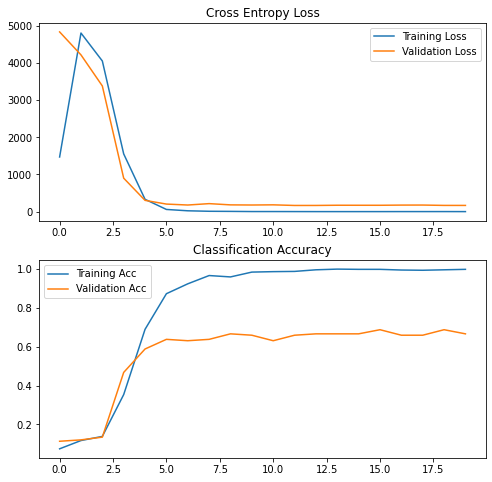

In [23]:
accuracy_loss_curves(history)

In [24]:
y_pred = model_pretrained.predict(X_test).argmax(axis=1)
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

             Ariel Sharon       0.82      0.82      0.82        11
    Arnold Schwarzenegger       0.33      0.20      0.25         5
             Colin Powell       0.88      0.88      0.88         8
          Donald Rumsfeld       0.64      0.78      0.70         9
            George W Bush       0.85      0.85      0.85        13
        Gerhard Schroeder       0.67      0.73      0.70        11
  Gloria Macapagal Arroyo       0.83      0.71      0.77         7
              Hugo Chavez       0.69      0.82      0.75        11
           Jacques Chirac       0.75      0.60      0.67         5
            Jean Chretien       0.80      0.50      0.62         8
        Jennifer Capriati       0.70      0.78      0.74         9
            John Ashcroft       0.83      0.71      0.77         7
        Junichiro Koizumi       0.50      1.00      0.67         3
               Laura Bush       1.00      1.00      1.00     

On voit qu'en entrainant seulement 20 epochs on a des résultats similaires à notre propre modèlde de reconnaissance faciale. 

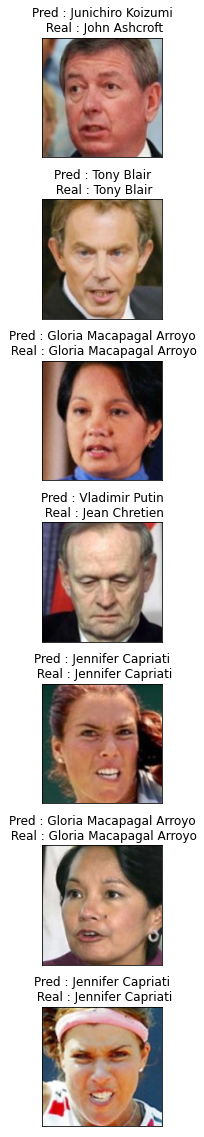

In [25]:
predictions=[]
for i in range(y_pred.shape[0]-1):
    predictions.append("Pred : "+target_names[y_pred[i]]+"\n Real : "+target_names[y_test[i]])

plot_gallery(X_test, predictions, 7,1)

#Attaque Projected Gradient Descent (PGD)

On a vu que les deux modèles précédent avaient de plutot bonne performance. Voyons comment l'attaque du projected gradient descent va affecter ces dernières.

L'attaque PGD est une attaque white-box, ce qui signifie que l'attaquant a accès aux gradients du modèle, c'est-à-dire qu'il possède une copie des poids du modèle. Ceci donne à l'attaquant beaucoup plus de pouvoir que les attaques de la boîte noire, car il peut élaborer spécifiquement son attaque pour tromper le modèle sans avoir à s'appuyer sur des attaques de transfert qui entraînent souvent des perturbations visibles par l'homme. La PGD peut être considérée comme l'attaque white-box le plus "complete", car elle lève toute contrainte sur le temps et les efforts que l'attaquant peut consacrer à la recherche de la meilleure attaque.

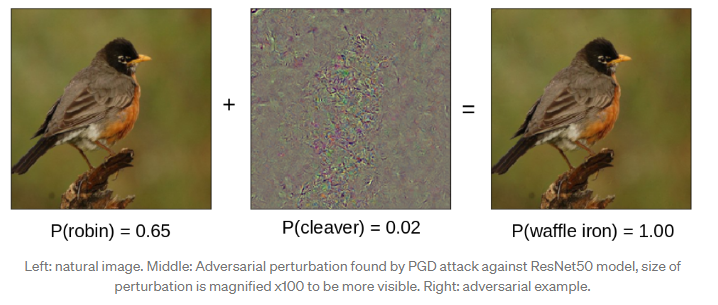

In [33]:
def generate_image_adversary(model, image, label , step = 10, eps=0.03):
  image = tf.cast(image, tf.float32)
  for i in range(step):
    with tf.GradientTape() as tape :
        tape.watch(image)
        pred = model(image)
        loss = sparse_categorical_crossentropy(label, pred)
        gradient = tape.gradient(loss, image)
        signedGrad = tf.sign(gradient)
        image = image + (signedGrad * eps)
  adversary = (image + (signedGrad * eps)).numpy()
  return adversary

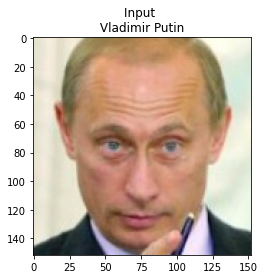

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


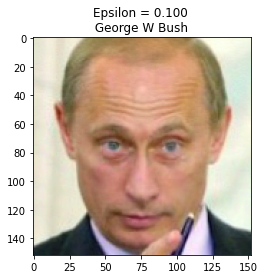

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


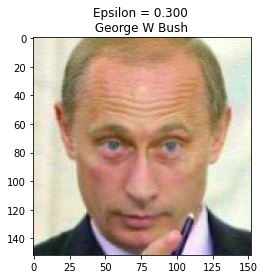

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


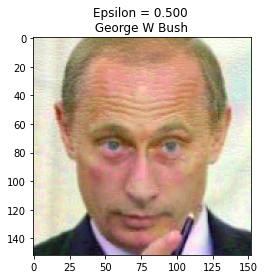

In [34]:
epsilons = [0, 0.1, 0.3, 0.5]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = generate_image_adversary(model, X_train[0:10], y_train[0:10], step=20, eps=eps)
    label = model.predict(adv_x).argmax(axis=1)
    plt.figure()
    plt.imshow(adv_x[4]/255)
    plt.title('{} \n {} '.format(descriptions[i],target_names[label[4]]))
    plt.show()

On voit qu'avec epsilon = 0.1 l'attaque est indicernable pour l'oeil humain et pourtant arrive à tromper le modèle.

Voyons comment l'attaque va affecter les performances du premier modèle. Nous prenons epsilon = 0.1 et nous faisons 20 step d'attaque

In [40]:
X_adv = generate_image_adversary(model, X_test, y_test, step=20, eps=0.1)
y_pred = model.predict(X_adv).argmax(axis=1)
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

             Ariel Sharon       0.20      0.09      0.13        11
    Arnold Schwarzenegger       0.00      0.00      0.00         5
             Colin Powell       0.00      0.00      0.00         8
          Donald Rumsfeld       0.00      0.00      0.00         9
            George W Bush       0.00      0.00      0.00        13
        Gerhard Schroeder       0.00      0.00      0.00        11
  Gloria Macapagal Arroyo       0.00      0.00      0.00         7
              Hugo Chavez       0.00      0.00      0.00        11
           Jacques Chirac       0.00      0.00      0.00         5
            Jean Chretien       0.00      0.00      0.00         8
        Jennifer Capriati       0.00      0.00      0.00         9
            John Ashcroft       0.00      0.00      0.00         7
        Junichiro Koizumi       0.00      0.00      0.00         3
               Laura Bush       0.00      0.00      0.00     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Notre modèle est completement incapable d'identifier correctement les visages attaqués. Il a des résultats pire qu'un modèle random


Voyons comment s'en sort le modèle deep face

In [41]:
X_adv = generate_image_adversary(model_pretrained, X_test, y_test, step=20, eps=0.1)
y_pred = model_pretrained.predict(X_adv).argmax(axis=1)
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

             Ariel Sharon       0.64      0.82      0.72        11
    Arnold Schwarzenegger       0.20      0.20      0.20         5
             Colin Powell       0.86      0.75      0.80         8
          Donald Rumsfeld       0.58      0.78      0.67         9
            George W Bush       0.92      0.85      0.88        13
        Gerhard Schroeder       0.75      0.55      0.63        11
  Gloria Macapagal Arroyo       0.71      0.71      0.71         7
              Hugo Chavez       0.69      0.82      0.75        11
           Jacques Chirac       0.75      0.60      0.67         5
            Jean Chretien       0.75      0.38      0.50         8
        Jennifer Capriati       0.64      0.78      0.70         9
            John Ashcroft       0.71      0.71      0.71         7
        Junichiro Koizumi       0.50      1.00      0.67         3
               Laura Bush       1.00      1.00      1.00     

Avec eps = 0.1, le modèle est toujours aussi performant. Voyons si c'est toujours le cas avec epsilon = 0.5

In [44]:
X_adv = generate_image_adversary(model_pretrained, X_test, y_test, step=20, eps=0.5)
y_pred = model_pretrained.predict(X_adv).argmax(axis=1)
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

             Ariel Sharon       0.64      0.82      0.72        11
    Arnold Schwarzenegger       0.17      0.20      0.18         5
             Colin Powell       0.86      0.75      0.80         8
          Donald Rumsfeld       0.58      0.78      0.67         9
            George W Bush       0.92      0.85      0.88        13
        Gerhard Schroeder       0.86      0.55      0.67        11
  Gloria Macapagal Arroyo       0.71      0.71      0.71         7
              Hugo Chavez       0.75      0.82      0.78        11
           Jacques Chirac       0.75      0.60      0.67         5
            Jean Chretien       0.75      0.38      0.50         8
        Jennifer Capriati       0.58      0.78      0.67         9
            John Ashcroft       0.71      0.71      0.71         7
        Junichiro Koizumi       0.50      1.00      0.67         3
               Laura Bush       1.00      1.00      1.00     

Le modèle deep face s'en sort très bien, sa presicion, son recall et son score F1 n'ont pas changé. Cela est du au fait que ce modèle à surement fait un adversarial training afin d'éviter d'être sensible aux attaques.